In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Dropout
from keras.models import Model
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import numpy as np
from keras.regularizers import l2
        

In [130]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.debugging.set_log_device_placement(False)

Num GPUs Available:  1


In [131]:
df = pd.read_parquet('../data/btcusd_preprcd_with_regimes.parquet')

df.dropna(inplace=True)

In [132]:
print(df.info())
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 292616 entries, 47 to 292662
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   open              292616 non-null  float64
 1   high              292616 non-null  float64
 2   low               292616 non-null  float64
 3   close             292616 non-null  float64
 4   BB_up_diff        292616 non-null  float64
 5   BB_down_diff      292616 non-null  float64
 6   OBV_Z             292616 non-null  float64
 7   MACD_Histogram    292616 non-null  float64
 8   RSI               292616 non-null  float64
 9   CCI               292616 non-null  float64
 10  predict_trend     292616 non-null  float64
 11  regime            292616 non-null  float64
 12  smoothed_regimes  292616 non-null  float64
dtypes: float64(13)
memory usage: 31.3 MB
None


open                0
high                0
low                 0
close               0
BB_up_diff          0
BB_down_diff        0
OBV_Z               0
MACD_Histogram      0
RSI                 0
CCI                 0
predict_trend       0
regime              0
smoothed_regimes    0
dtype: int64

In [133]:
def calculate_future_price(df, window=3):
    def weight_average(x):
        return np.dot(x, [0.45, 0.3, 0.25])
    df['future_price'] = df['close'].rolling(window=window).apply(weight_average, raw=True).shift(-window)
    return df
df = calculate_future_price(df, window=3)

In [134]:
import pandas as pd
import numpy as np

def create_features(df):
    # Moving averages
    windows = [5, 20]
    for w in windows:
        df[f'SMA_{w}'] = df['close'].rolling(w).mean()
        df[f'EMA_{w}'] = df['close'].ewm(span=w).mean()
    
    # Momentum
    df['ROC_5'] = df['close'].pct_change(5)
    df['ROC_20'] = df['close'].pct_change(20)
    df['MACD_MA_5'] = df['MACD_Histogram'].rolling(5).mean()
    
    # Volatility
    df['BB_width'] = df['BB_up_diff'] - df['BB_down_diff']
    df['high-low'] = df['high'] - df['low']
    df['close_prev'] = df['close'].shift(1)
    df['high-close_prev'] = df['high'] - df['close_prev']
    df['low-close_prev'] = df['low'] - df['close_prev']
    df['TR'] = df[['high-low', 'high-close_prev', 'low-close_prev']].max(axis=1)
    df['ATR_14'] = df['TR'].rolling(14).mean()
    
    # Interactions
    df['RSI_CCI'] = df['RSI'] * df['CCI']
    df['OBV_MACD'] = df['OBV_Z'] * df['MACD_Histogram']
    
    # Statistical features
    df['RSI_zscore'] = (df['RSI'] - df['RSI'].rolling(20).mean()) / df['RSI'].rolling(20).std()
    df['RSI_CCI_corr'] = df['RSI'].rolling(20).corr(df['CCI'])
    
    return df.dropna()

# Usage:
df = create_features(df)


In [135]:
def preprocess_data(train_df):
    # Calculate log returns for price columns
    for col in ['open', 'high', 'low', 'close']:
        train_df[f'{col}_log_return'] = np.log(train_df[col] / train_df[col].shift(1))
    
    # Create additional features
    train_df['price_mean'] = train_df[['open', 'high', 'low', 'close']].mean(axis=1)
    train_df['price_std'] = train_df[['open', 'high', 'low', 'close']].std(axis=1)
    train_df['price_range'] = train_df['high'] - train_df['low']
    # Standard scaling for MACD and CCI
    std_cols = ['MACD_Histogram', 'CCI']
    std_scaler = StandardScaler().fit(train_df[std_cols])
    train_df[std_cols] = std_scaler.transform(train_df[std_cols])
    
    # Normalize RSI to focus on the 30–70 range
    train_df['RSI'] = np.clip(train_df['RSI'], 30, 70)
    rsi_scaler = MinMaxScaler(feature_range=(0, 1)).fit(train_df[['RSI']])
    train_df['RSI'] = rsi_scaler.transform(train_df[['RSI']])
    
    # Add lagged features for RSI, MACD, CCI, and predict_trend
    for col in ['RSI', 'MACD_Histogram', 'CCI']:
        for lag in range(1, 10):  # Add 4 lagged intervals
            train_df[f'{col}_lag_{lag}'] = train_df[col].shift(lag)
    for col in ['predict_trend']:
        for lag in range(1, 10):
            train_df[f'{col}_lag_{lag}'] = train_df[col].shift(lag+3)
    # Drop rows with NaN values (caused by lagging)
    train_df.dropna(inplace=True)
    
    return train_df

In [136]:
df.columns

Index(['open', 'high', 'low', 'close', 'BB_up_diff', 'BB_down_diff', 'OBV_Z',
       'MACD_Histogram', 'RSI', 'CCI', 'predict_trend', 'regime',
       'smoothed_regimes', 'future_price', 'SMA_5', 'EMA_5', 'SMA_20',
       'EMA_20', 'ROC_5', 'ROC_20', 'MACD_MA_5', 'BB_width', 'high-low',
       'close_prev', 'high-close_prev', 'low-close_prev', 'TR', 'ATR_14',
       'RSI_CCI', 'OBV_MACD', 'RSI_zscore', 'RSI_CCI_corr'],
      dtype='object')

In [137]:
df['predict_trend'].describe()

count    292593.000000
mean          0.828322
std         143.946962
min       -6669.066665
25%         -21.666667
50%           0.185333
75%          23.282667
max        6293.066669
Name: predict_trend, dtype: float64

In [138]:
df = preprocess_data(df)
sc = StandardScaler()
df['predict_trend'] = sc.fit_transform(df[['predict_trend']])

In [139]:
df.head()

,open,high,low,close,BB_up_diff,BB_down_diff,OBV_Z,MACD_Histogram,RSI,CCI,...,CCI_lag_9,predict_trend_lag_1,predict_trend_lag_2,predict_trend_lag_3,predict_trend_lag_4,predict_trend_lag_5,predict_trend_lag_6,predict_trend_lag_7,predict_trend_lag_8,predict_trend_lag_9
79,646.53,649.20,645.87,649.20,12.453662,-3.675662,-0.472583,-0.037885,0.225794,-0.693708,...,-0.754542,-2.282667,-7.515333,-5.200000,-2.805333,-2.661333,0.169333,-0.966000,-0.604000,-0.353333
80,649.39,650.93,649.20,649.27,11.718864,-4.041864,-0.175740,-0.031963,0.000000,-0.593891,...,-0.092767,1.912667,-2.282667,-7.515333,-5.200000,-2.805333,-2.661333,0.169333,-0.966000,-0.604000
81,649.27,649.82,648.19,648.65,12.260267,-3.928267,-0.874383,-0.027759,0.000000,-0.622696,...,-0.619284,2.328667,1.912667,-2.282667,-7.515333,-5.200000,-2.805333,-2.661333,0.169333,-0.966000
82,648.65,648.96,646.63,648.17,12.639695,-3.979695,-1.250301,-0.024548,0.000000,-0.624402,...,-0.423893,1.909333,2.328667,1.912667,-2.282667,-7.515333,-5.200000,-2.805333,-2.661333,0.169333
83,648.23,648.98,646.68,648.27,12.372836,-4.540836,-0.785012,-0.021069,0.000000,-0.515360,...,-0.408454,-0.595333,1.909333,2.328667,1.912667,-2.282667,-7.515333,-5.200000,-2.805333,-2.661333


In [140]:
y = df['predict_trend']
x = df.drop(columns=['predict_trend'])
x_train = x[:int(len(x)*0.6)]
y_train = y[:int(len(x)*0.6)]
x_val = x[int(len(x)*0.6):int(len(x)*0.8)]
y_val = y[int(len(x)*0.6):int(len(x)*0.8)]
x_test = x[int(len(x)*0.8):]
y_test = y[int(len(x)*0.8):]

In [141]:
x_train = np.nan_to_num(x_train, nan=0.0, posinf=0.0, neginf=0.0)
y_train = np.nan_to_num(y_train, nan=0.0, posinf=0.0, neginf=0.0)
x_val = np.nan_to_num(x_val, nan=0.0, posinf=0.0, neginf=0.0)
y_val = np.nan_to_num(y_val, nan=0.0, posinf=0.0, neginf=0.0)

In [142]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

/opt/anaconda3/envs/Universal/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [143]:
y_train.shape

(175548,)

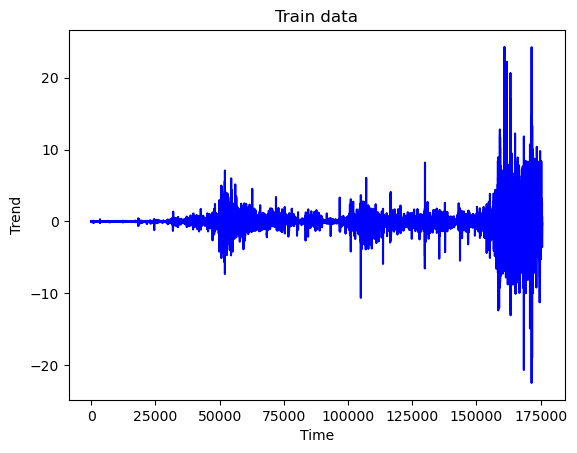

In [144]:
sns.lineplot(data=y_train, color='blue')

plt.title('Train data')
plt.xlabel('Time')
plt.ylabel('Trend')
plt.show()


In [145]:
from keras.regularizers import l2
from keras.optimizers import Adam

model = Sequential()
model.add(LSTM(100, input_shape=(x_train.shape[1], 1), return_sequences=True))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))


optimizer = Adam()  # Clip gradients to prevent exploding
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])


/opt/anaconda3/envs/Universal/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [146]:
model.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_val, y_val), verbose=1)

Epoch 1/5


2025-03-22 19:44:11.767576: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


5486/5486 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.6001 - mae: 0.3019

2025-03-22 19:49:47.841912: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


5486/5486 ━━━━━━━━━━━━━━━━━━━━ 376s 68ms/step - loss: 0.6001 - mae: 0.3019 - val_loss: 1.2533 - val_mae: 0.6757
Epoch 2/5
5486/5486 ━━━━━━━━━━━━━━━━━━━━ 378s 69ms/step - loss: 0.5744 - mae: 0.2983 - val_loss: 1.2532 - val_mae: 0.6757
Epoch 3/5
5486/5486 ━━━━━━━━━━━━━━━━━━━━ 381s 70ms/step - loss: 0.5833 - mae: 0.2973 - val_loss: 1.2532 - val_mae: 0.6757
Epoch 4/5
5486/5486 ━━━━━━━━━━━━━━━━━━━━ 389s 71ms/step - loss: 0.6021 - mae: 0.3017 - val_loss: 1.2532 - val_mae: 0.6757
Epoch 5/5
5486/5486 ━━━━━━━━━━━━━━━━━━━━ 390s 71ms/step - loss: 0.5854 - mae: 0.3000 - val_loss: 1.2534 - val_mae: 0.6757


In [147]:
model.save('../models/time_series_market_model4.h5')

In [148]:
from keras.metrics import MeanSquaredError
import joblib

custom_objects = {'mse': MeanSquaredError()}

model_n = tf.keras.models.load_model('../models/time_series_market_model4.h5', custom_objects=custom_objects)
# joblib.dump(sc, '../models/scaler.pkl')
# joblib.dump(model_n, '../models/model_timeseries2.joblib')
y_pred = model_n.predict(x_test)


2025-03-22 20:16:05.952077: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1829/1829 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step


In [149]:
print(y_pred[0])

[0.00509537]


In [150]:
y_pred = sc.inverse_transform(np.array(y_pred).reshape(-1, 1))
y_test = sc.inverse_transform(np.array(y_test).reshape(-1, 1))

In [151]:
y_pred[0]

array([1.5618881], dtype=float32)

In [152]:
threshold = 500
take_profit = 300
signals_pred = np.where(y_pred > 600, 1, np.where(y_pred < -300, -1, 0)).astype(int)
signals_test = np.where(y_test > take_profit, 1, np.where(y_test < -take_profit, -1, 0)).astype(int)

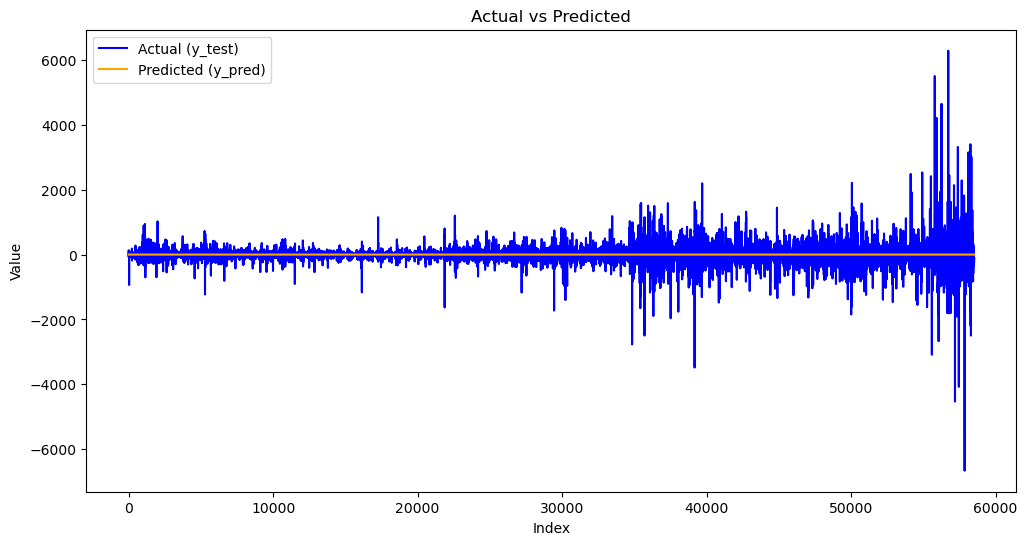

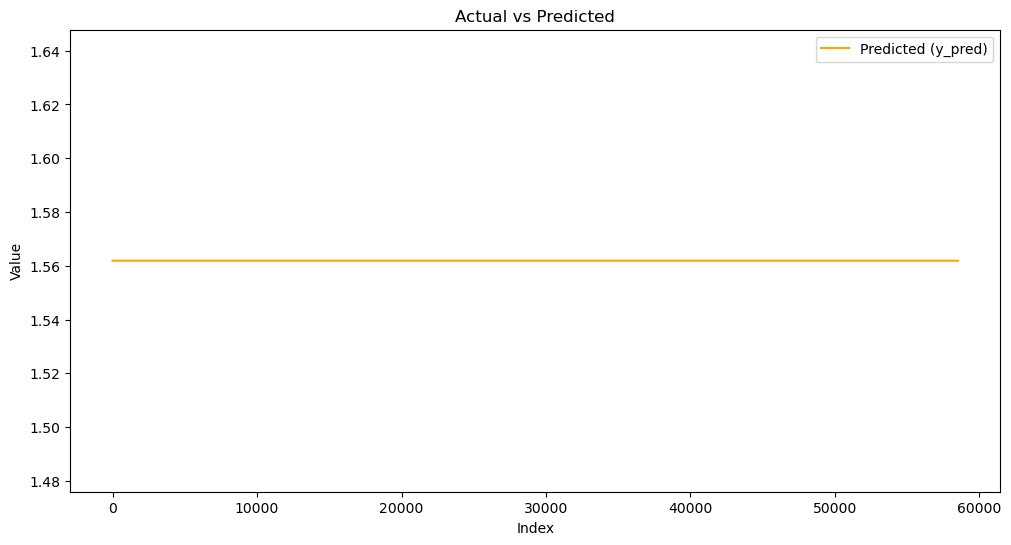

In [153]:
data = pd.DataFrame({
    'Index': range(len(y_test)),
    'y_test': y_test.flatten(),  # Use .values to get NumPy array
    'y_pred': y_pred.flatten()   # Use .values to get NumPy array
})

# Plot the data
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Index', y='y_test', label='Actual (y_test)', color='blue')
sns.lineplot(data=data, x='Index', y='y_pred', label='Predicted (y_pred)', color='orange')

# Add labels and legend
plt.title('Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Index', y='y_pred', label='Predicted (y_pred)', color='orange')

# Add labels and legend
plt.title('Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [154]:
print("Unique values in signals_test:", np.unique(signals_test))
print("Unique values in signals_pred:", np.unique(signals_pred))

Unique values in signals_test: [-1  0  1]
Unique values in signals_pred: [0]


In [155]:
from sklearn.metrics import classification_report
print(classification_report(y_pred=signals_pred, y_true=signals_test, labels=[-1, 0, 1]))


              precision    recall  f1-score   support

          -1       0.00      0.00      0.00      1994
           0       0.93      1.00      0.96     54270
           1       0.00      0.00      0.00      2253

    accuracy                           0.93     58517
   macro avg       0.31      0.33      0.32     58517
weighted avg       0.86      0.93      0.89     58517



/opt/anaconda3/envs/Universal/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/Universal/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/Universal/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu